Build a toy shapes dataset. Strongly inspired from [this implementation](https://github.com/matterport/Mask_RCNN/blob/cbff80f3e3f653a9eeee43d0d383a0385aba546b/samples/shapes/shapes.py).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
import tifffile

import sys; sys.path.append("../../../")
import maskflow

import utils

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

config = maskflow.load_config("config.yaml")

# Copy config next to data folder
maskflow.save_config(config, root_dir / "config.yaml")

class_names = ["circle", "triangle", "square"]

## Generate the dataset

In [6]:
height = config["INPUT"]["MAX_SIZE_TRAIN"]
width = config["INPUT"]["MAX_SIZE_TRAIN"]
count = 50
max_n_per_image = 10
training_size = 0.9

train_ids, _ = train_test_split(np.arange(0, count), train_size=training_size)

train_dir = data_dir / "train_dataset"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = data_dir / "test_dataset"
test_dir.mkdir(parents=True, exist_ok=True)

train_annotations_path = data_dir / "train_annotations.json"
test_annotations_path = data_dir / "test_annotations.json"

train_annotations = maskflow.get_base_annotations(class_names, supercategory="shape")
test_annotations = maskflow.get_base_annotations(class_names, supercategory="shape")

annotation_id = 1

for image_id in tqdm.trange(count):
    # Generate image specification
    bg_color, shapes = utils.random_image(height, width, max_n_per_image, class_names)
    
    # Generate the image
    image = utils.generate_image(bg_color, height, width, shapes)
    
    # Generate the mask
    mask, class_ids = utils.generate_mask(bg_color, height, width, shapes, class_names)
    
    basename = f"toy_{image_id:04d}.tif"
    
    # Get the annotation in the COCO format.
    image_info, image_annotations = maskflow.get_annotations(image_id, basename, image, mask, class_ids)
    
    if image_id in train_ids:
        image_path = train_dir / basename
        train_annotations["images"].append(image_info)
        train_annotations["annotations"].extend(image_annotations)
    else:
        image_path = test_dir / basename
        test_annotations["images"].append(image_info)
        test_annotations["annotations"].extend(image_annotations)
    
    tifffile.imsave(str(image_path), image)
    
maskflow.save_annotations(train_annotations, train_annotations_path)
maskflow.save_annotations(test_annotations, test_annotations_path)

100%|██████████| 50/50 [00:00<00:00, 99.97it/s]


## Visualize some images with annotations

In [11]:
data_loader = maskflow.get_data_loader(config, data_dir, is_train=False)

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
dataset = [data_loader.__iter__() for _ in range(4)]

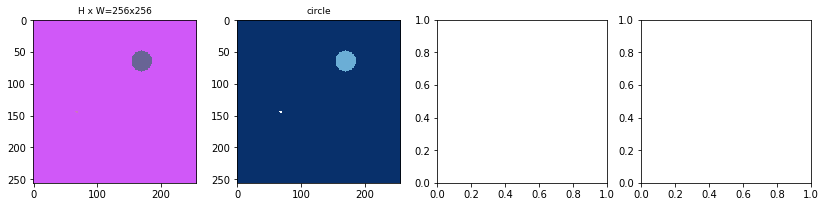

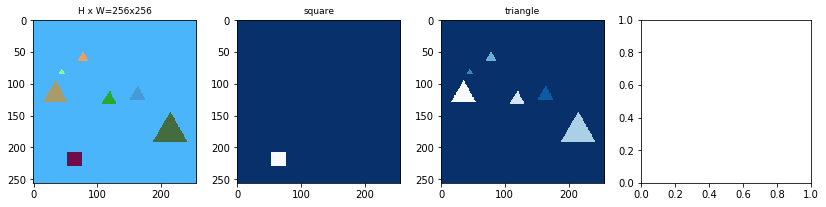

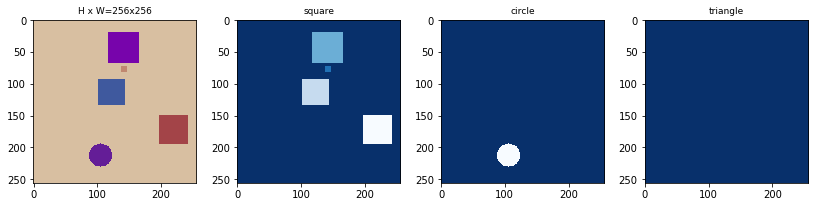

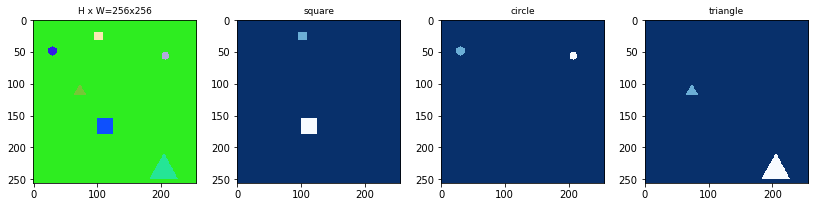

In [3]:
# Select the training dataset
tfrecord_path = data_dir / "training_data.tfrecord"

# Retrieve some data
images, annotations = maskflow.get_data(data_loader, n=4, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"], class_names, limit=3)